In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import FinanceDataReader as fdr
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, LSTM, Activation, BatchNormalization, Dropout
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers

In [2]:
df_samsung = fdr.DataReader('005930')

In [3]:
df_samsung.reset_index(inplace=True)

In [4]:
df_samsung['Date'] = pd.to_datetime(df_samsung['Date'])
df_samsung

,Date,Open,High,Low,Close,Volume,Change
0,1998-05-08,1213,1232,1200,1210,333190,NaN
1,1998-05-09,1210,1225,1210,1216,64040,0.004959
2,1998-05-11,1215,1221,1191,1192,195520,-0.019737
3,1998-05-12,1182,1200,1156,1177,243650,-0.012584
4,1998-05-13,1163,1219,1148,1205,359030,0.023789
...,...,...,...,...,...,...,...
5995,2022-07-06,57300,57300,56400,56400,16820461,-0.013986
5996,2022-07-07,56400,58700,56300,58200,21322833,0.031915
5997,2022-07-08,58600,59300,58200,58700,15339271,0.008591
5998,2022-07-11,59300,59600,58700,58800,13042624,0.001704


In [5]:
cols = list(df_samsung)[1:-2]
df_for_trainig = df_samsung[cols].astype(float)
df_for_trainig.isna().sum()

Open     0
High     0
Low      0
Close    0
dtype: int64

In [6]:
scaler = StandardScaler()
scaler = scaler.fit(df_for_trainig)
df_for_trainig_scaled = scaler.transform(df_for_trainig)

In [7]:
train_x = []
train_y = []

n_future = 1
n_past = 14

for i in range(n_past, len(df_for_trainig_scaled) - n_future):
    train_x.append(df_for_trainig_scaled[i - n_past:i, 0:df_for_trainig.shape[1]])
    train_y.append(df_for_trainig_scaled[i + n_future - 1:i + n_future, 0])

train_x, train_y = np.array(train_x), np.array(train_y)
train_x.shape, train_y.shape

((5985, 14, 4), (5985, 1))

In [26]:
num_step = 5
num_unit = 200

input_layer = Input(batch_shape=(None, train_x.shape[1], train_x.shape[2]))

layer_lstm1 = LSTM(num_unit, return_sequences=True, recurrent_regularizer=regularizers.l2(0.01))(input_layer)
layer_lstm1 = BatchNormalization()(layer_lstm1)

layer_lstm2 = LSTM(num_unit, return_sequences=True, recurrent_regularizer=regularizers.l2(0.01))(layer_lstm1)
layer_lstm2 = Dropout(0.25)(layer_lstm2)

layer_lstm3 = LSTM(num_unit, return_sequences=True, recurrent_regularizer=regularizers.l2(0.01))(layer_lstm2)
layer_lstm3 = BatchNormalization()(layer_lstm3)

layer_lstm4 = LSTM(num_unit, return_sequences=True, recurrent_regularizer=regularizers.l2(0.01))(layer_lstm3)
layer_lstm4 = Dropout(0.25)(layer_lstm4)

layer_lstm5 = LSTM(num_unit, recurrent_regularizer=regularizers.l2(0.01))(layer_lstm4)
layer_lstm5 = BatchNormalization()(layer_lstm5)

output_layer = Dense(2, activation='sigmoid')(layer_lstm5)

model = Model(input_layer, output_layer)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy', 'mse'])
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 14, 4)]           0         
                                                                 
 lstm_19 (LSTM)              (None, 14, 200)           164000    
                                                                 
 batch_normalization_9 (Batc  (None, 14, 200)          800       
 hNormalization)                                                 
                                                                 
 lstm_20 (LSTM)              (None, 14, 200)           320800    
                                                                 
 dropout_8 (Dropout)         (None, 14, 200)           0         
                                                                 
 lstm_21 (LSTM)              (None, 14, 200)           320800    
                                                           

In [10]:
model = Sequential()
model.add(LSTM(128, activation='relu', input_shape=(train_x.shape[1], train_x.shape[2]), return_sequences=True))
model.add(LSTM(64, activation='relu', return_sequences=False))
# model.add(LSTM(64, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(train_y.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 14, 128)           68096     
                                                                 
 lstm_7 (LSTM)               (None, 64)                49408     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 117,569
Trainable params: 117,569
Non-trainable params: 0
_________________________________________________________________


In [11]:
history = model.fit(train_x, train_y, epochs=10, batch_size=16, validation_split=0.1, verbose=1)

Epoch 1/10
337/337 [==============================] - 6s 12ms/step - loss: 0.0280 - val_loss: 0.0795
Epoch 2/10
337/337 [==============================] - 4s 10ms/step - loss: 0.0152 - val_loss: 0.0276
Epoch 3/10
337/337 [==============================] - 4s 11ms/step - loss: 0.0138 - val_loss: 0.0801
Epoch 4/10
337/337 [==============================] - 4s 11ms/step - loss: 0.0121 - val_loss: 0.0613
Epoch 5/10
337/337 [==============================] - 4s 11ms/step - loss: 0.0124 - val_loss: 0.1527
Epoch 6/10
337/337 [==============================] - 4s 11ms/step - loss: 0.0120 - val_loss: 0.0969
Epoch 7/10
337/337 [==============================] - 4s 11ms/step - loss: 0.0114 - val_loss: 0.0052
Epoch 8/10
337/337 [==============================] - 4s 11ms/step - loss: 0.0111 - val_loss: 0.0928
Epoch 9/10
337/337 [==============================] - 4s 11ms/step - loss: 0.0113 - val_loss: 0.0173
Epoch 10/10
337/337 [==============================] - 3s 10ms/step - loss: 0.0105 - val_lo

In [13]:
n_future = 90
train_dates = pd.to_datetime(df_samsung['Date'])

forecast_period_dates = pd.date_range(list(train_dates)[-1], periods=n_future, freq='1d').tolist()

In [14]:
forecast = model.predict(train_x[-n_future:])

3/3 [==============================] - 0s 5ms/step


In [15]:
forecast_copies = np.repeat(forecast, df_for_trainig.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(forecast_copies)[:,0]

In [16]:
forecast_dates = []

for time_i in forecast_period_dates:
    forecast_dates.append(time_i.date())

In [17]:
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Open':y_pred_future})
df_forecast['Date'] = pd.to_datetime(df_forecast['Date'])

In [18]:
original = df_samsung[['Date', 'Open']]
original['Date'] = pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2020-1-1']

c:\Users\hoon9\anaconda3\envs\main\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


C:\Users\hoon9\AppData\Roaming\Python\Python37\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\hoon9\AppData\Roaming\Python\Python37\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Date', ylabel='Open'>

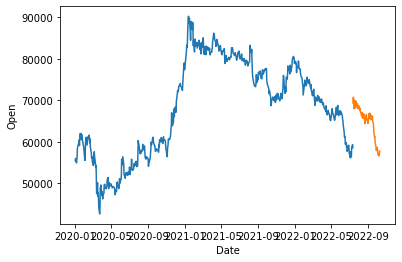

In [19]:
sns.lineplot(original['Date'], original['Open'])
sns.lineplot(df_forecast['Date'], df_forecast['Open'])